In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ACTION_SPACE = ('U', 'D', 'L', 'R')

In [3]:
class Grid:
    def __init__(self, rows, columns, start):
        self.rows = rows
        self.columns = columns
        self.i = start[0]
        self.j = start[1]

    def set_rewards_actions(self, rewards, actions):
        self.rewards = rewards
        self.actions = actions
    
    def get_state(self):
        return (self.i, self.j)

    def set_state(self, s):
        self.i = s[0]
        self.j = s[1]

    def get_next_state(self, s, a):
        i, j = s[0], s[1]
        if a in self.actions[(i, j)]:
            if a == 'U':
                i -= 1
            elif a == 'D':
                i += 1
            elif a == 'L':
                j -= 1
            elif a == 'R':
                j += 1
        return i, j
    
    def move(self, a):
        if a in self.actions[(self.i, self.j)]:
            if a == 'U':
                self.i -= 1
            elif a == 'D':
                self.i += 1
            elif a == 'L':
                self.j -= 1
            elif a == 'R':
                self.j += 1
        return self.rewards.get((self.i, self.j), 0)
    
    def undo_move(self, a):
        if a == 'U':
            self.i += 1
        elif a == 'D':
            self.i -= 1
        elif a == 'L':
            self.j += 1
        elif a == 'R':
            self.j -= 1
        assert (self.get_state() in self.all_states())
    
    def is_terminal(self, s):
        return s not in self.actions

    def game_over(self):
        return (self.i, self.j) not in self.actions

    def all_states(self):
        return set(self.actions.keys() | self.rewards.keys())

In [4]:
def grid_standard():
    g = Grid(3, 4, (2, 0))
    rewards = {
        (0,3): 1,
        (1,3): -1
    }
    
    actions = {
        (0, 0): ('D', 'R'),
        (0, 1): ('L', 'R'),
        (0, 2): ('L', 'D', 'R'),
        (1, 0): ('U', 'D'),
        (1, 2): ('U', 'D', 'R'),
        (2, 0): ('U', 'R'),
        (2, 1): ('L', 'R'),
        (2, 2): ('U', 'L', 'R'),
        (2, 3): ('U', 'L')
    }

    g.set_rewards_actions(rewards, actions)

    return g

In [5]:
def print_values(V, g):
    for i in range(g.rows):
        print("-------------------------")
        for j in range(g.columns):
            v = V.get((i, j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="")
        print("")

def print_policy(P, g):
    for i in range(g.rows):
        print("-------------------------")
        for j in range(g.columns):
            a = P.get((i, j), ' ')
            print(" %s |" % a, end="")
        print("")

In [6]:
def t_probs_rewards(g):
    transition_probs = {}

    rewards = {}

    for i in range(g.rows):
        for j in range(g.columns):
            s = (i, j)
            if not g.is_terminal(s):
                for a in ACTION_SPACE:
                    s_next = g.get_next_state(s, a)
                    transition_probs[(s, a, s_next)] = 1 # prob of s with action to reach s_next is 1 because deterministic
                    if s_next in g.rewards:
                        rewards[(s, a, s_next)] = g.rewards[s_next]
    return transition_probs, rewards

In [7]:
def evaluate_deterministic_policy(g, policy):
    V = {}
    for s in g.all_states():
        V[s] = 0
    iterations = 0

    while True:
        biggest_change = 0
        for s in g.all_states():
            old_v = V[s]
            new_v = 0
            for a in ACTION_SPACE:
                for s_next in g.all_states():
                    action_prob = 1 if policy.get(s) == a else 0

                    r = rewards.get((s, a, s_next), 0)

                    new_v += action_prob * transition_probs.get((s, a, s_next), 0) * (r + gamma * V[s_next])

            V[s] = new_v
            biggest_change = max(biggest_change, np.abs(old_v - V[s]))

        iterations += 1
        if biggest_change < delta:
            break

    return V

In [8]:
def get_optimal_policy(g, policy):
    while True:
        V = evaluate_deterministic_policy(g, policy)

        is_policy_converged = True
        for s in g.actions.keys():
            old_a = policy[s]
            new_a = None
            best_value = float('-inf')

            for a in ACTION_SPACE:
                v = 0
                for s_next in g.all_states():
                    r = rewards.get((s, a, s_next), 0)
                    v += transition_probs.get((s, a, s_next), 0) * (r + gamma * V[s_next])

                if v > best_value:
                    best_value = v
                    new_a = a
            
            policy[s] = new_a

            if new_a != old_a:
                is_policy_converged = False
            
        if is_policy_converged:
            break
    return V, policy

In [9]:
# initialize variable
g = grid_standard()
delta = 1e-4
gamma = 0.9

# random policy
policy = {}
for s in g.actions.keys():
    policy[s] = np.random.choice(ACTION_SPACE)

print("initial policy")
print_policy(policy, g)
print("")

transition_probs, rewards = t_probs_rewards(g)

V, policy = get_optimal_policy(g, policy)
print("optimal policy")
print_policy(policy, g)
print("V")
print_values(V, g)

initial policy
-------------------------
 U | R | R |   |
-------------------------
 D |   | D |   |
-------------------------
 R | R | U | U |

optimal policy
-------------------------
 R | R | R |   |
-------------------------
 U |   | U |   |
-------------------------
 U | R | U | L |
V
-------------------------
 0.81| 0.90| 1.00| 0.00|
-------------------------
 0.73| 0.00| 0.90| 0.00|
-------------------------
 0.66| 0.73| 0.81| 0.73|


## Monte Carlo

In [10]:
def random_action(a, eps=0.1):
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ACTION_SPACE)

In [11]:
def play_game(g, policy):
    start_states = list(g.actions.keys())
    start_idx = np.random.choice(len(start_states))
    g.set_state(start_states[start_idx])

    s = g.get_state()
    states_and_rewards = [(s, 0)] # at the start reward = 0

    while not g.game_over(): # update (s, r) for every state visited based on policy
        a = policy[s]
        a = random_action(a)
        r = g.move(a)
        s = g.get_state()
        states_and_rewards.append((s, r))

    G = 0
    states_and_returns = []
    first = True

    for s, r in reversed(states_and_rewards): # backwards iteration from terminal state
        if first:
            first = False
        else:
            states_and_returns.append((s, G))
        
        G = r + gamma * G
    states_and_returns.reverse()
    return states_and_returns

In [12]:
def play_game_random_start_action(g, policy):
    # start_states = list(g.actions.keys())
    # start_idx = np.random.choice(len(start_states))
    s = (2, 0)
    g.set_state(s)

    a = random_action(policy[s])

    states_actions_rewards = [(s, a, 0)]
    seen_states = set() # record visited states
    seen_states.add(s)
    n_steps = 0

    while True:
        old_s = g.get_state()
        r = g.move(a)
        s = g.get_state()
        n_steps += 1

        # if s in seen_states: # prevent infinite looping in several states because using standard grid
        #     r = -0.1 / n_steps
        #     states_actions_rewards.append((s, None, r))
        if old_s == s:
            states_actions_rewards.append((s, None, -100))
            break
        elif g.game_over():
            states_actions_rewards.append((s, None, r))
            break
        else:
            a = random_action(policy[s])
            states_actions_rewards.append((s, a, r))
        seen_states.add(s)

    G = 0
    states_actions_returns = []
    first = True

    for s, a, r in reversed(states_actions_rewards): # backwards iteration from terminal state
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        
        G = r + gamma * G
    states_actions_returns.reverse()
    return states_actions_returns

In [13]:
def max_dict(d):
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

### Monte Carlo Evaluation

In [14]:
def monte_carlo(g, policy, V, returns, num_of_iter):
    for t in range(num_of_iter):
        states_and_returns = play_game(g, policy)
        seen_states = set()

        for s, G in states_and_returns:
            if s not in seen_states:
                returns[s].append(G)
                V[s] = np.mean(returns[s])
                seen_states.add(s)
    
    return V, policy

### Monte Carlo Improvement

In [15]:
def monte_carlo_improvement(g, policy, Q, returns, deltas, num_of_iter):
    for t in range(num_of_iter):
        if t % 1000 == 0:
            print(t)

        states_actions_returns = play_game_random_start_action(g, policy)
        seen_states_actions = set()

        biggest_change = 0
        for s, a, G in states_actions_returns:
            sa = (s, a)
            if sa not in seen_states_actions:
                old_Q = Q[s][a]
                returns[sa].append(G)
                Q[s][a] = np.mean(returns[sa])
                biggest_change = max(biggest_change, np.abs(old_Q - Q[s][a]))
                seen_states_actions.add(sa)

        deltas.append(biggest_change)

        for s in policy.keys():
            policy[s] = max_dict(Q[s])[0]
    
    return Q, policy, deltas

### Run Monte Carlo

In [16]:
g = grid_standard()

print("rewards:")
print_values(g.rewards, g)

policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'U',
    (2, 1): 'L',
    (2, 2): 'U',
    (2, 3): 'L',
}

V = {}
returns = {}

for s in g.all_states():
    if s in g.actions:
        returns[s] = []
    else:
        V[s] = 0

V, policy = monte_carlo(g, policy, V, returns, 5000)

print("values")
print_values(V, g)
print("policy")
print_policy(policy, g)

rewards:
-------------------------
 0.00| 0.00| 0.00| 1.00|
-------------------------
 0.00| 0.00| 0.00|-1.00|
-------------------------
 0.00| 0.00| 0.00| 0.00|
values
-------------------------
 0.78| 0.88| 0.99| 0.00|
-------------------------
 0.70| 0.00| 0.84| 0.00|
-------------------------
 0.62| 0.56| 0.75| 0.63|
policy
-------------------------
 R | R | R |   |
-------------------------
 U |   | U |   |
-------------------------
 U | L | U | L |


rewards:
-------------------------
 0.00| 0.00| 0.00| 1.00|
-------------------------
 0.00| 0.00| 0.00|-1.00|
-------------------------
 0.00| 0.00| 0.00| 0.00|
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


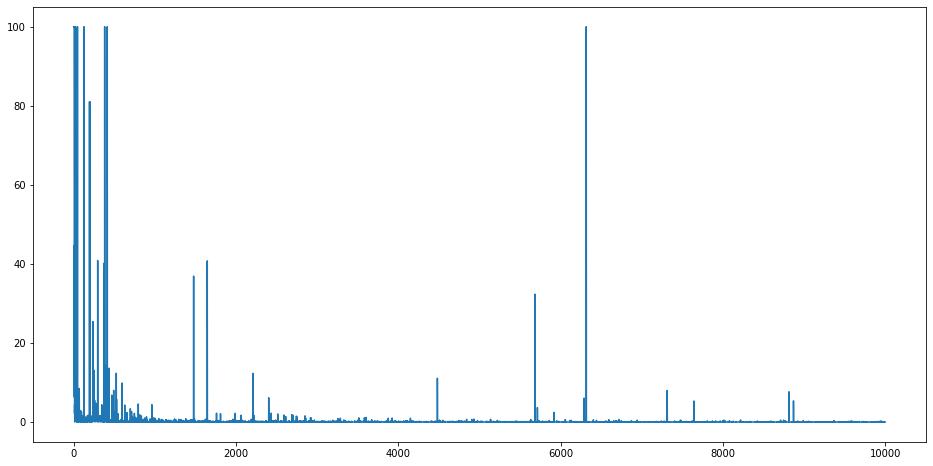

final values
-------------------------
-6.34|-1.73| 1.00| 0.00|
-------------------------
-10.23| 0.00|-1.00| 0.00|
-------------------------
-13.76|-15.96|-25.66|-1.00|
optimal policy
-------------------------
 R | R | R |   |
-------------------------
 U |   | R |   |
-------------------------
 U | L | R | U |


In [17]:
g = grid_standard()

print("rewards:")
print_values(g.rewards, g)

policy = {}
for s in list(g.actions.keys()):
    policy[s] = np.random.choice(ACTION_SPACE)

Q = {}
returns = {}
for s in g.all_states():
    if s in g.actions:
        Q[s] = {}
        for a in ACTION_SPACE:
            Q[s][a] = 0
            returns[(s,a)] = []


deltas = []

Q, policy, deltas = monte_carlo_improvement(g, policy, Q, returns, deltas, 10000)

plt.figure(figsize=(16,8))
plt.plot(deltas)
plt.show()

V = {}
for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]
print("final values")
print_values(V, g)


print("optimal policy")
print_policy(policy, g)

## Approximation Monte Carlo

In [18]:
def s2x(s):
    return np.array([s[0] - 1, s[1] - 1.5, s[0] * s[1] - 3, 1])

rewards:
-------------------------
 0.00| 0.00| 0.00| 1.00|
-------------------------
 0.00| 0.00| 0.00|-1.00|
-------------------------
 0.00| 0.00| 0.00| 0.00|
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


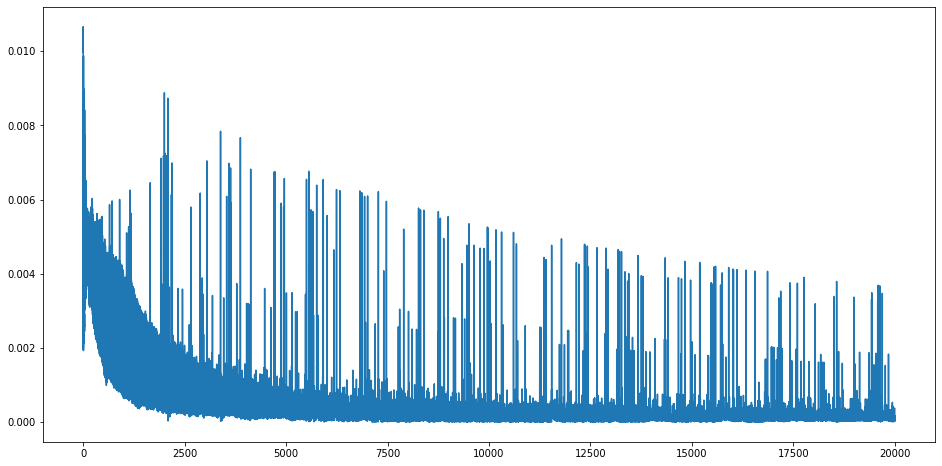

final values
-------------------------
 0.76| 0.88| 0.99| 0.00|
-------------------------
 0.70| 0.00| 0.83| 0.00|
-------------------------
 0.63| 0.64| 0.66| 0.68|
optimal policy
-------------------------
 R | R | R |   |
-------------------------
 U |   | U |   |
-------------------------
 U | L | U | L |


In [21]:
g = grid_standard()

delta = 1e-4
gamma = 0.9
lr = 0.001

print("rewards:")
print_values(g.rewards, g)

policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'U',
    (2, 1): 'L',
    (2, 2): 'U',
    (2, 3): 'L',
}

theta = np.random.randn(4) / 2

deltas = []
t = 1.0

for it in range(20000):
    if it % 100 == 0:
        t += 0.01
    if it % 1000 == 0:
        print(it)

    alpha = lr / t

    biggest_change = 0
    states_and_returns = play_game(g, policy)
    seen_states = set()

    for s, G in states_and_returns:
        if s not in seen_states:
            old_theta = theta.copy()
            x = s2x(s)
            V_hat = theta.dot(x)

            theta += alpha * (G - V_hat) * x
            biggest_change = max(biggest_change, np.abs(old_theta - theta).sum())
            seen_states.add(s)
    deltas.append(biggest_change)

plt.figure(figsize=(16, 8))
plt.plot(deltas)
plt.show()

V = {}
for s in g.all_states():
    if s in list(g.actions.keys()):
        V[s] = theta.dot(s2x(s))
    else:
        V[s] = 0

print("final values")
print_values(V, g)


print("optimal policy")
print_policy(policy, g)